# AOS_PS1_lsstCam

9010121 : lsstCam high extra qckBkgndPert00.cmd

Run on hyak with 

    python /gscratch/astro/suberlak/aos/AOS/run_ps1_phosim.py --instruments lsstCam --fields high --positions extra --root_dir /gscratch/astro/suberlak/aos/AOS/DM-28360 --cmd_file qckBkgndPert00_hyak.cmd --phosim_path /gscratch/astro/brycek/ts_repos/phosim_syseng4/phosim.py --phosim_p 192

Moved the raw amp data to NCSA (running on hyak the following : 

    scp -rp /gscratch/astro/suberlak/aos/AOS/DM-28360/lsstCam/high/extra/9010121/raw/  scichris@lsst-login01.ncsa.illinois.edu:/project/scichris/aos/AOS/DM-28360/lsstCam/high/extra/9010121/raw/

) 

Repackaged (on NCSA LSP): 

    phosim_repackager.py /project/scichris/aos/AOS/DM-28360/lsstCam/high/extra/9010121/raw/raw     --out_dir /project/scichris/aos/AOS/DM-28360/lsstCam/high/extra/9010121/repackaged --inst lsst --focusz -1500

Ingested and ISRd:

    python run_ps1_3_butler.py --obshistids 9010121
    
    

In [2]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
def plot_raw_postISR(repo_dir,instrument,detector='R22_S11'):
    
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded'],
                             )


    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]
    print(exp_num)
    zscale = ZScaleInterval()
     
    # initialize the figure 
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    # get the raw exposure 
    exposure = butler.get('raw', detector=detector, instrument=instrument,
              exposure=exp_num,)

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[0].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[0].set_title("raw")
    ax[0].set_xlabel('x [px]')
    ax[0].set_ylabel('y [px]')

    # get the postISR exposure 
    exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
              exposure=exp_num,collections=['run1'])

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[1].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[1].set_title("postISR")
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    fig.suptitle(f"{instrument} {exposure.getDetector().getName()}",
                fontsize=18)

    

Show the high extra field for few sensors:

In [6]:
#These two parameters are the same for all cells below:
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/lsstCam/high/extra/9010121/DATA/'

The corner intra-focal SW1, i.e. 'high', has a smaller z-coord in CCS. Since we moved by -1500 in  phosim coordinates, this implies moving  by  +1500 in CCS, which brings this sensor from z_CCS = -1500 to  z_CCS = -1500+1500 =  0, i.e. now it is in-focus:

4021123110121


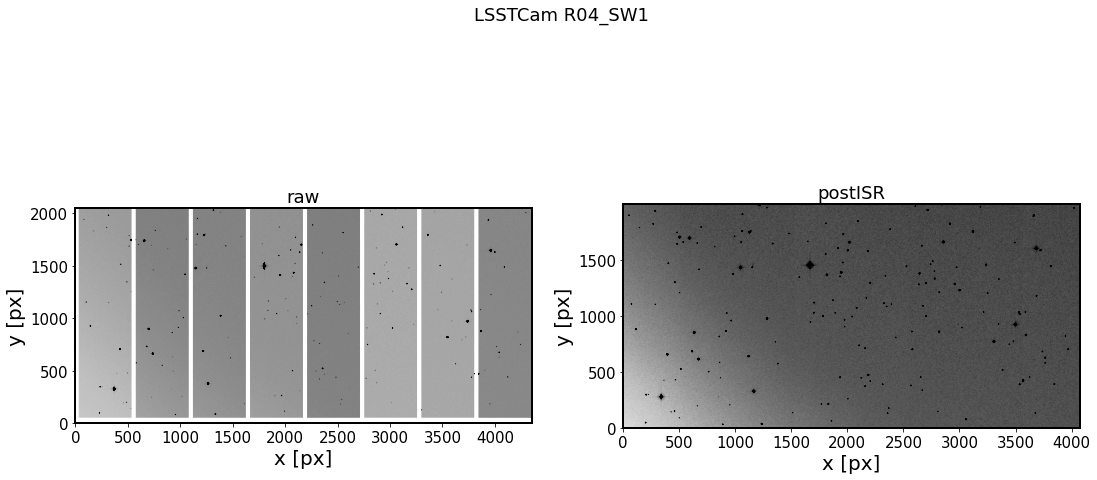

In [3]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW1') 

Likewise, the corner extra-focal SW0, i.e. 'low', has a larger z-coord in CCS. Moving by +1500 along +z in CCS brings it more out of focus (from z_CCS=+1500 now it is at z_CCS = 1500+1500 = +3000), i.e. the donuts will be too large:

4021123110121


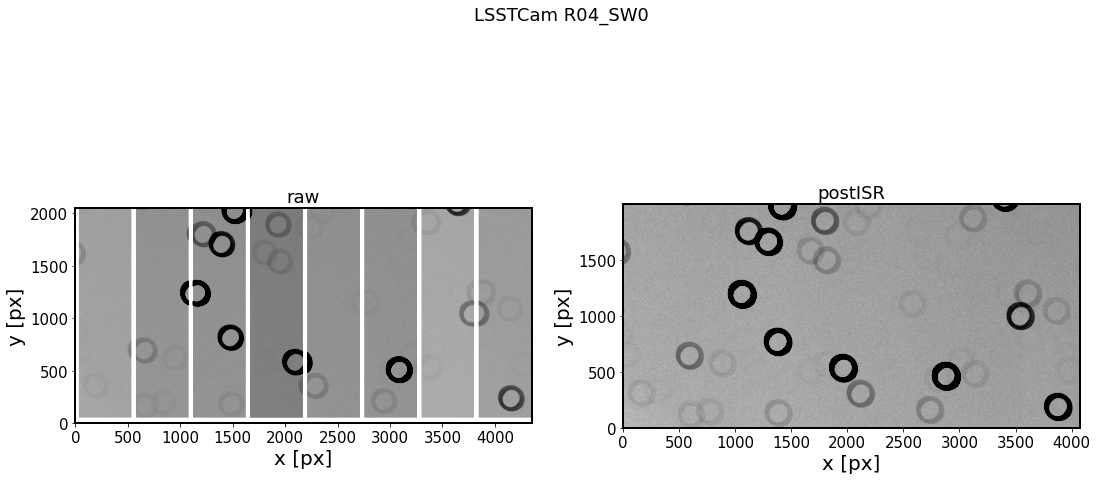

In [5]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW0') 

And all other sensors are moved from z_CCS = 0 to z_CCS = +1500 , i.e. they are out of focus: 

4021123110121


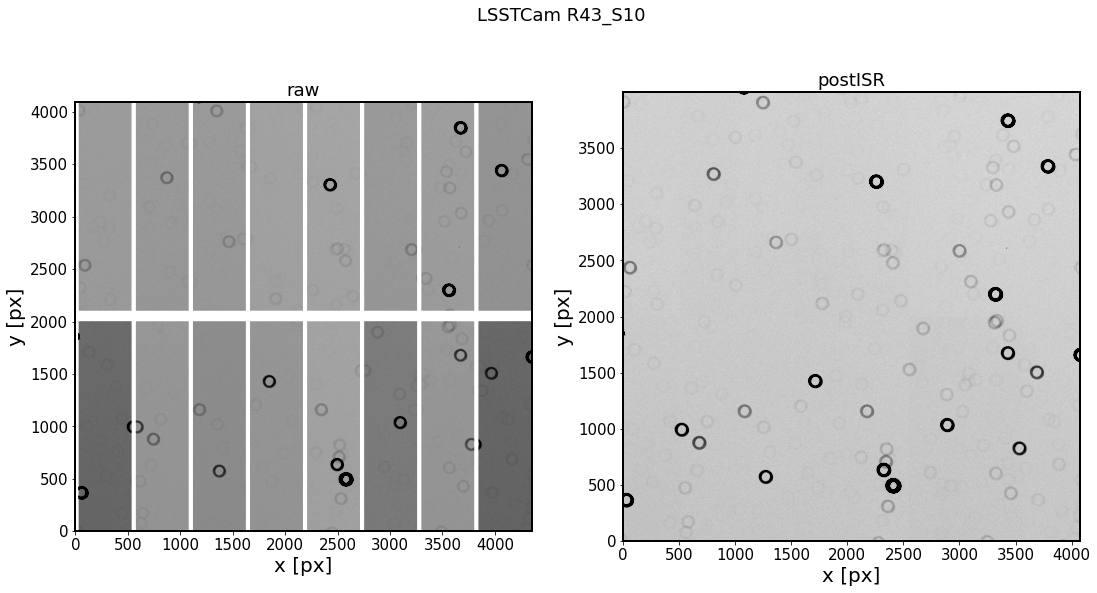

In [7]:
plot_raw_postISR(repo_dir,instrument, detector='R43_S10') 

The FAMcam sensors on the edges (R34_S22, R14_S02, R30_S20, R10_S00)  have very strong vignetting:

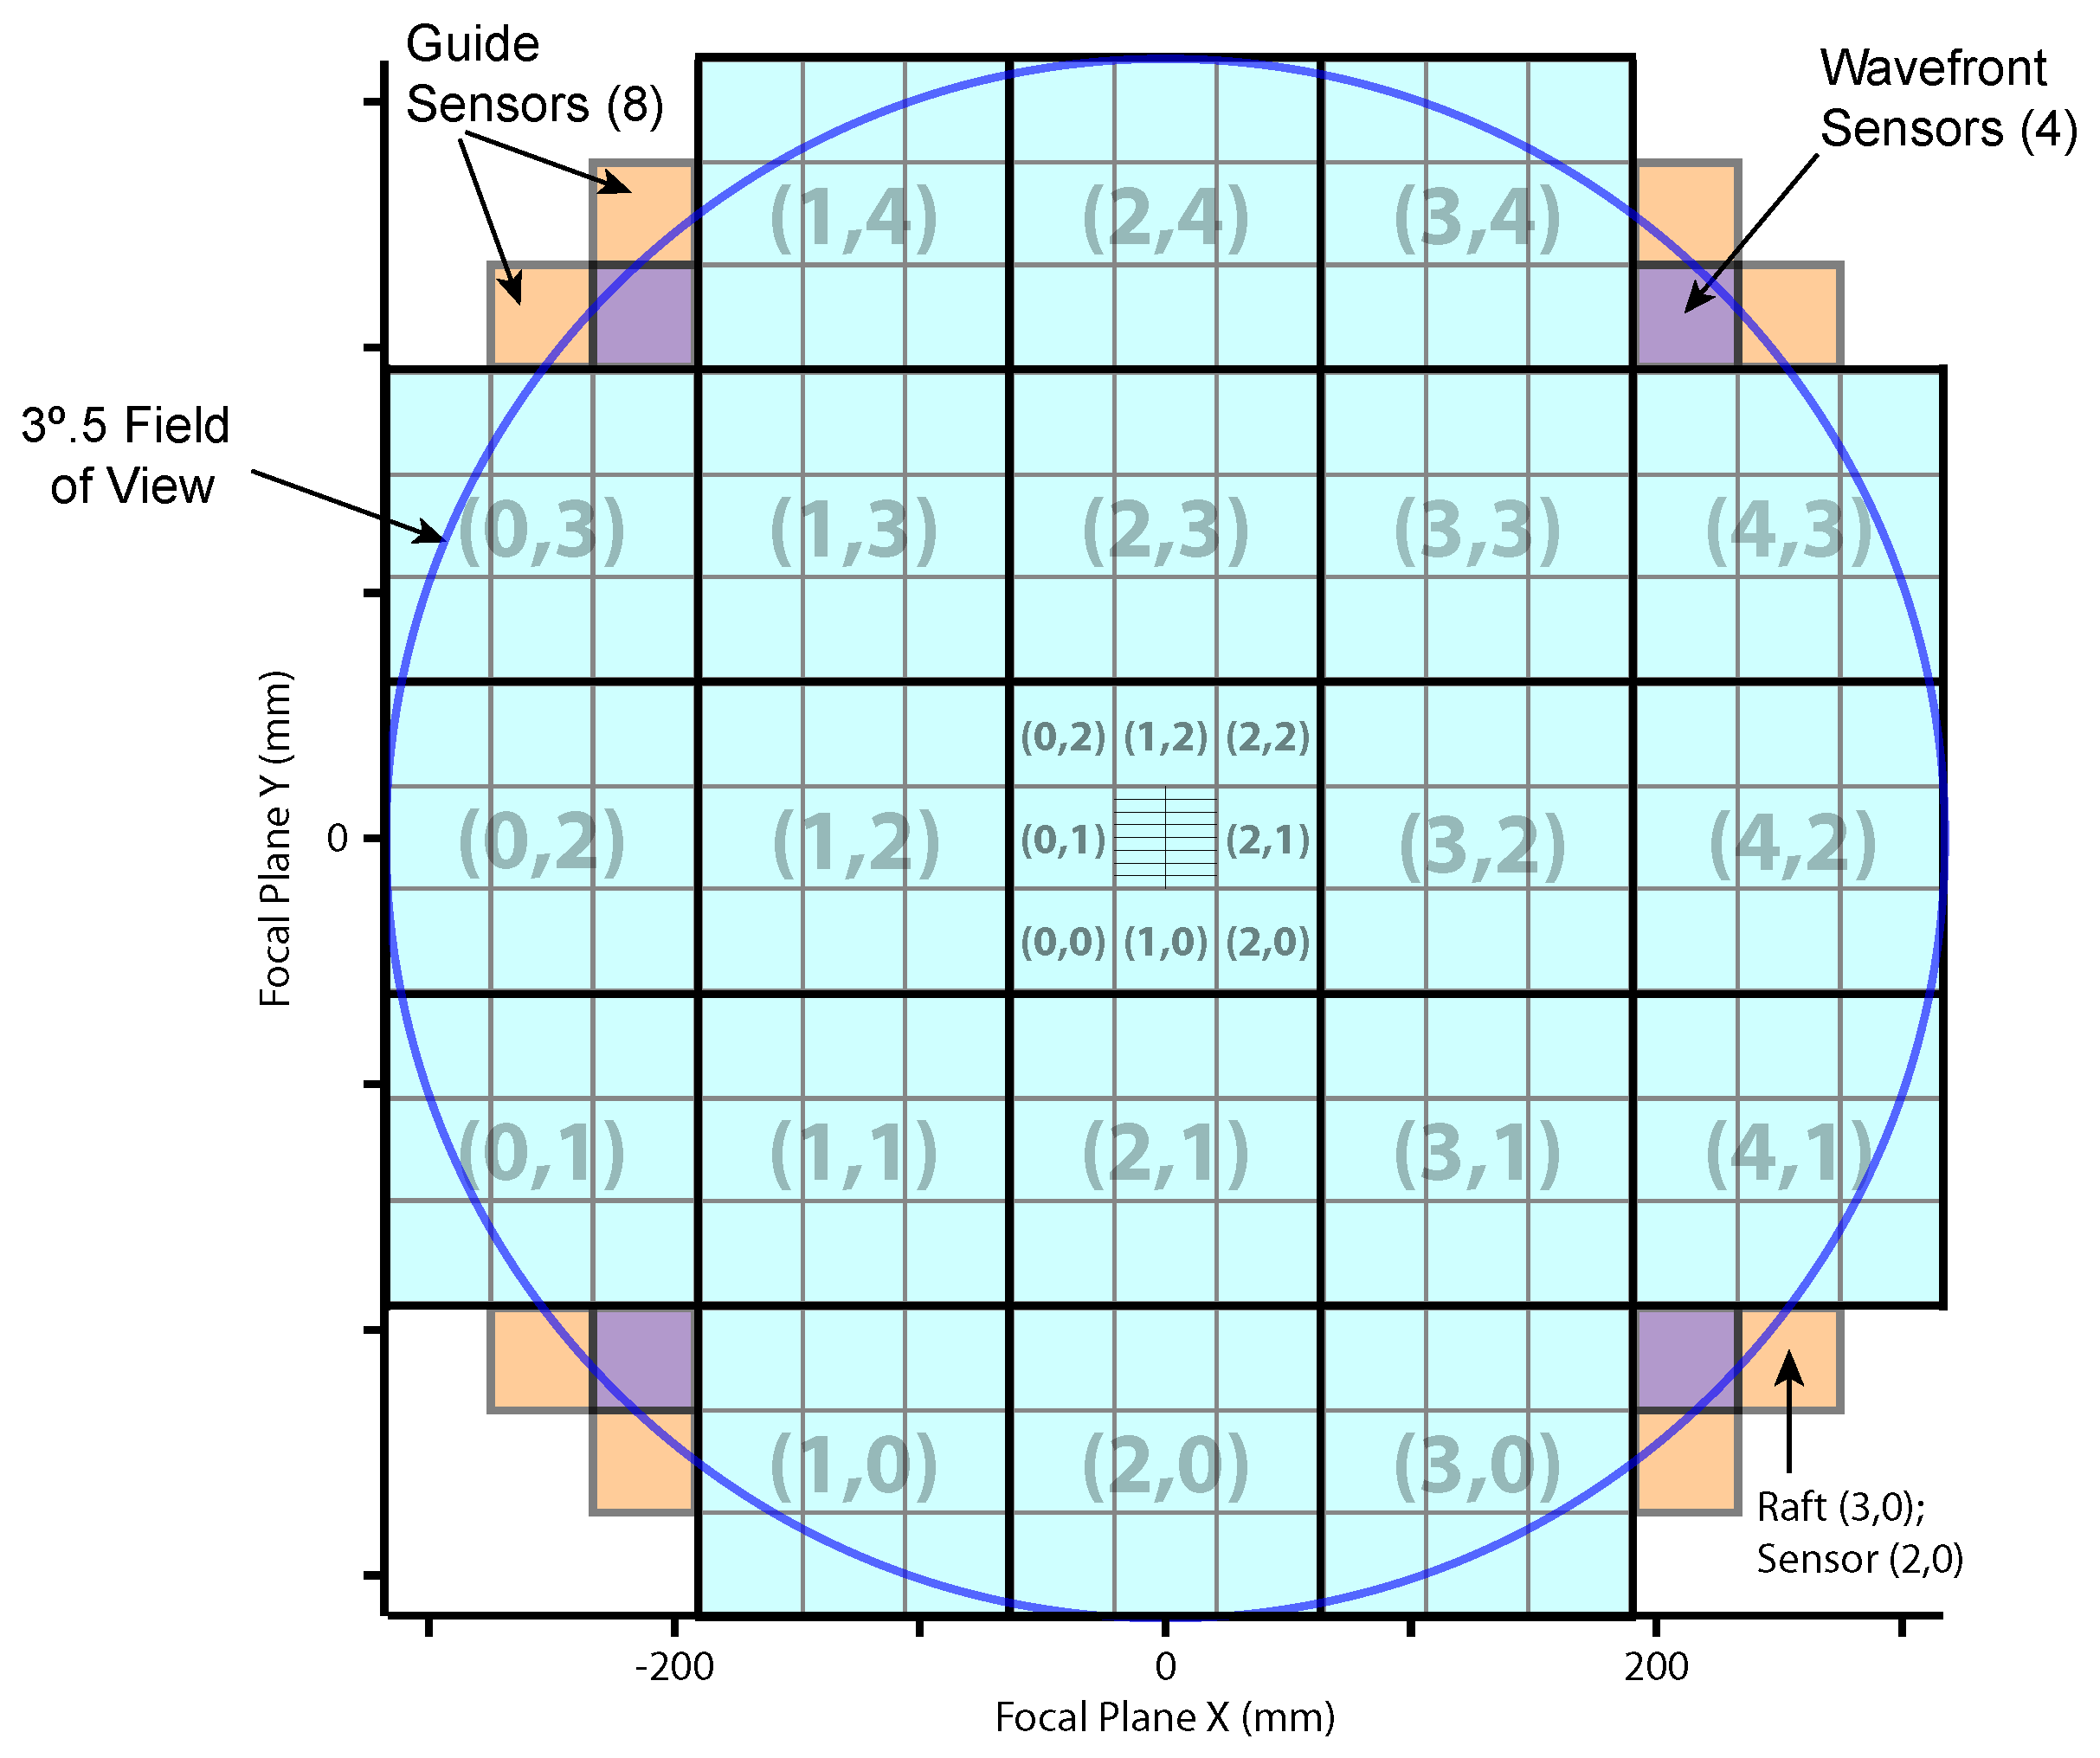

Upper-right corner:

4021123110121


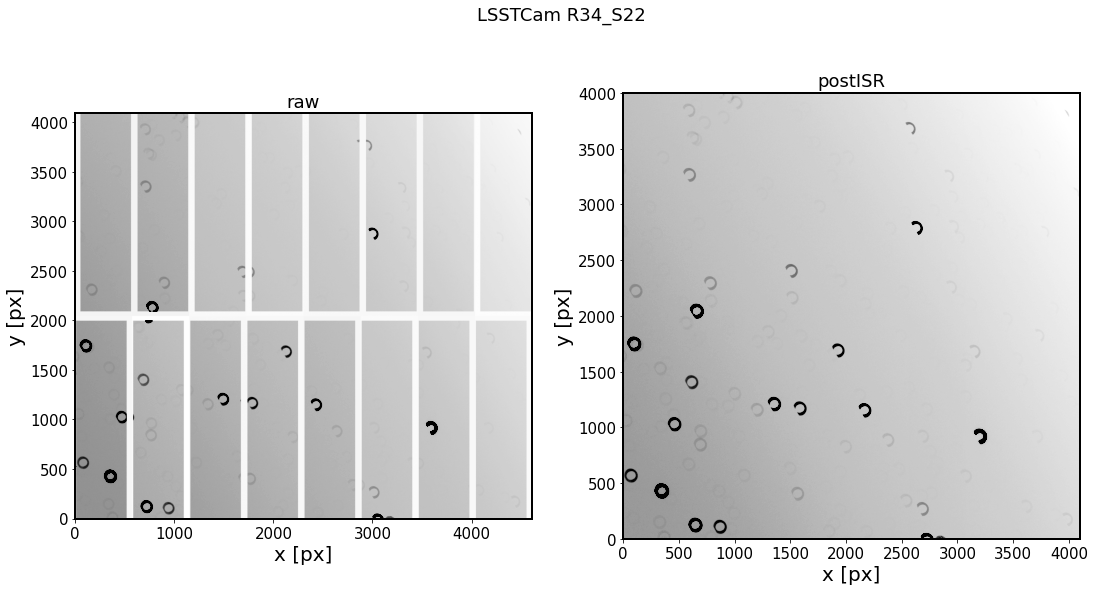

In [8]:
plot_raw_postISR(repo_dir,instrument, detector='R34_S22') 

Upper-left corner:

4021123110121


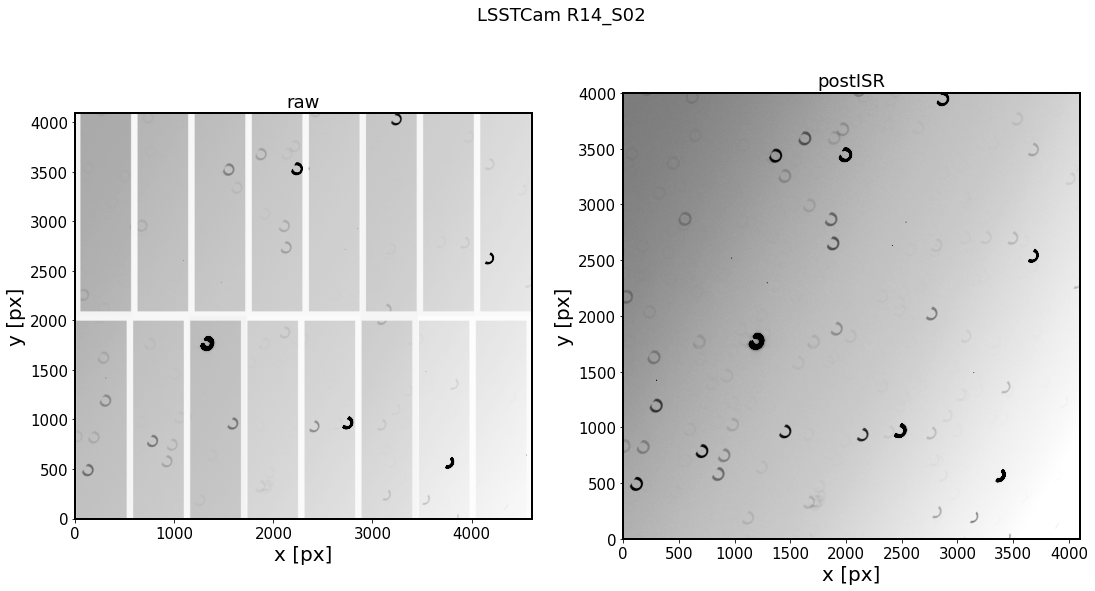

In [9]:
plot_raw_postISR(repo_dir,instrument, detector='R14_S02') 

Bottom-left:

4021123110121


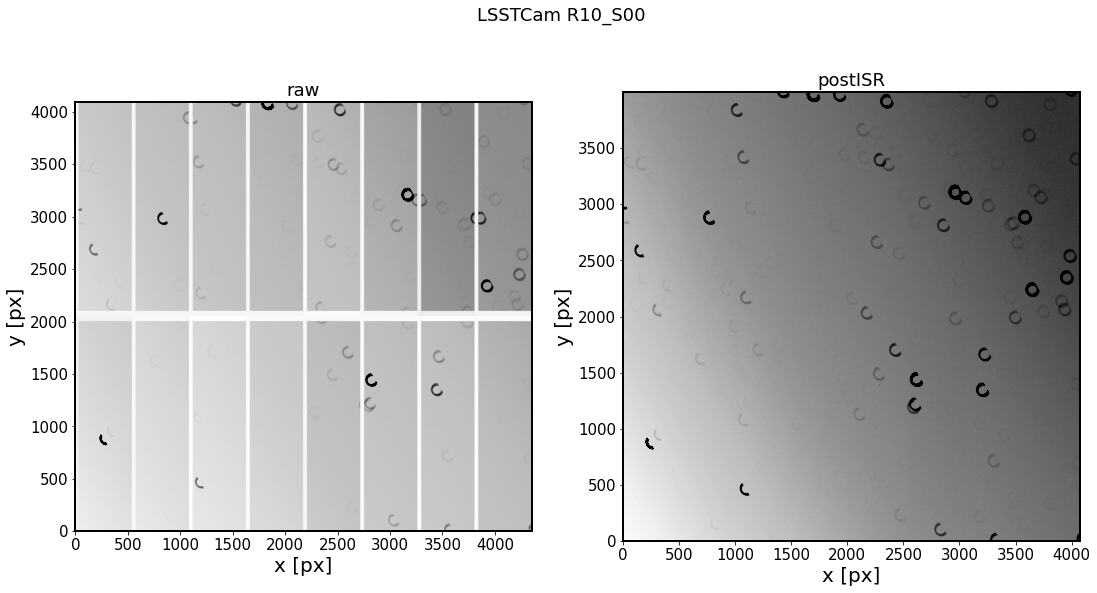

In [10]:
plot_raw_postISR(repo_dir,instrument, detector='R10_S00') 

Bottom-right:

4021123110121


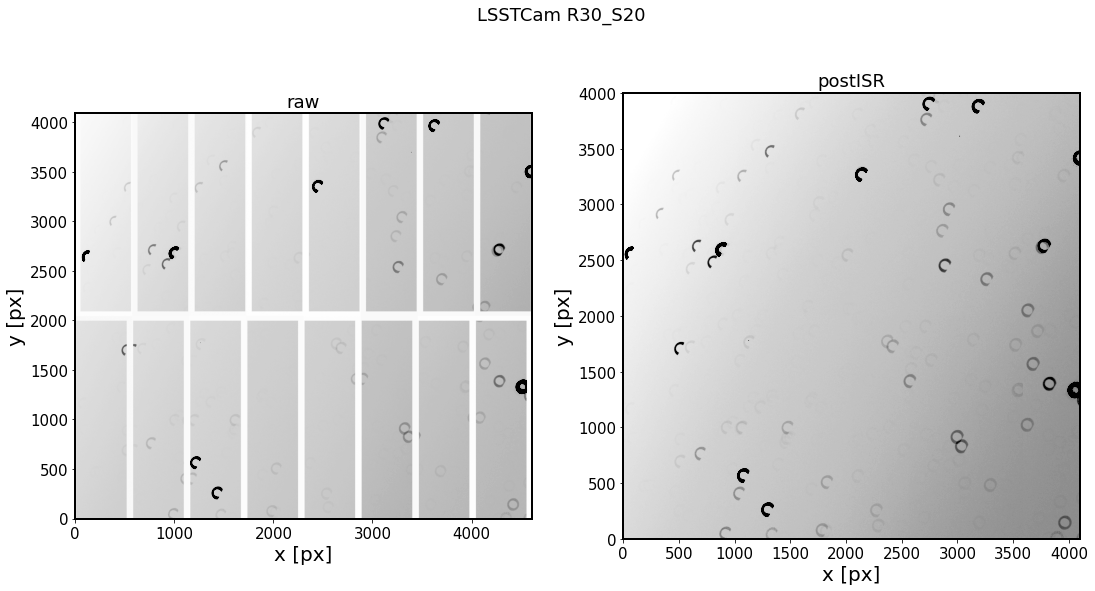

In [11]:
plot_raw_postISR(repo_dir,instrument, detector='R30_S20') 

Show a sensor somewhere in the middle:

4021123110121


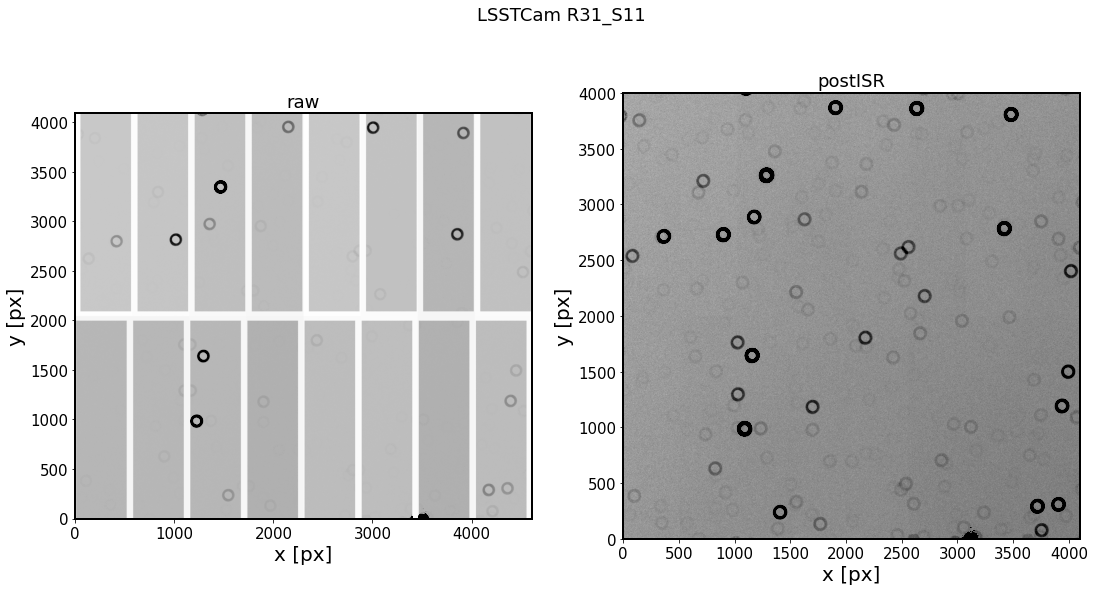

In [12]:
plot_raw_postISR(repo_dir,instrument, detector='R31_S11') 

Use `cameraGeom` to plot the entire focal plane:

In [13]:
afwDisplay.setDefaultBackend("matplotlib")

repo_dir = os.path.join('/project/scichris/aos/AOS/DM-28360/lsstCam/high/extra/9010121/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )

dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

exposure = dataset.dataId["exposure"]

camera  = butler.get("camera", instrument=instrument, exposure=exposure)

Reading 189: Dataset postISRCCD with data ID {instrument: 'LSSTCam', detector: 189, exposure: 4021123110121} could not be found in collections [LSSTCam/raw/all, LSSTCam/calib, run1, LSSTCam/calib/unbounded].
Reading 190: Dataset postISRCCD with data ID {instrument: 'LSSTCam', detector: 190, exposure: 4021123110121} could not be found in collections [LSSTCam/raw/all, LSSTCam/calib, run1, LSSTCam/calib/unbounded].
Reading 193: Dataset postISRCCD with data ID {instrument: 'LSSTCam', detector: 193, exposure: 4021123110121} could not be found in collections [LSSTCam/raw/all, LSSTCam/calib, run1, LSSTCam/calib/unbounded].
Reading 194: Dataset postISRCCD with data ID {instrument: 'LSSTCam', detector: 194, exposure: 4021123110121} could not be found in collections [LSSTCam/raw/all, LSSTCam/calib, run1, LSSTCam/calib/unbounded].
Reading 197: Dataset postISRCCD with data ID {instrument: 'LSSTCam', detector: 197, exposure: 4021123110121} could not be found in collections [LSSTCam/raw/all, LSSTCam

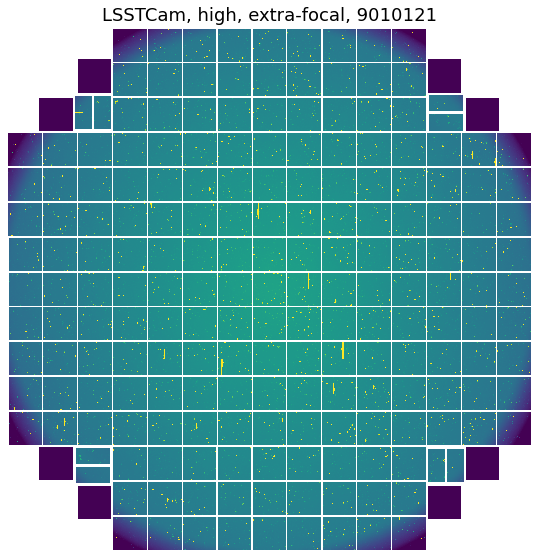

In [50]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0., wspace=0.0, )

ax = fig.add_subplot(1, 1, 1)

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=2)
#disp.scale('linear', 'minmax')
#disp.scale('asinh', 5, 7000, Q=2)

disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"


# use that  to limit what's shown
#detectorNameList = ['R22_S11', 'R22_S20', 'R22_S10']# , 'R34_S20'] 

# set to None to plot everything
detectorNameList = None
mos = cameraGeomUtils.showCamera(camera,
                             cameraGeomUtils.ButlerImage(butler, dataType, 
                                                         instrument=instrument, 
                                                         exposure=exposure,
                                                         verbose=True),
                             binSize=16, 
                             detectorNameList=detectorNameList, 
                             display=disp, overlay=False, title=f'{instrument}, high, extra-focal, 9010121' )
                             
disp.show_colorbar(False)
ax.axis("off")

plt.savefig('LsstCam_high_extra_9010121.png', bbox_inches='tight')

In [81]:
cameraGeomUtils.showCamera?

Signature:
cameraGeomUtils.showCamera(
    camera,
    imageSource=<lsst.afw.cameraGeom.utils.FakeImageDataSource object at 0x7fea6bc2a220>,
    imageFactory=<class 'lsst.afw.image.image.ImageF'>,
    detectorNameList=None,
    binSize=10,
    bufferSize=10,
    overlay=True,
    title='',
    showWcs=None,
    ctype='green',
    textSize=1.25,
    originAtCenter=True,
    display=None,
    **kwargs,
)
Docstring:
Show a Camera on display, with the specified display.

The rotation of the sensors is snapped to the nearest multiple of 90 deg.
Also note that the pixel size is constant over the image array. The lower
left corner (LLC) of each sensor amp is snapped to the LLC of the pixel
containing the LLC of the image.

Parameters
----------
camera : `lsst.afw.cameraGeom.Camera`
    Camera object to use to make the image.
imageSource : `FakeImageDataSource` or `None`
    Source to get ccd images.  Must have a ``getCcdImage()`` method.
imageFactory : `lsst.afw.image.Image`
    Type of image

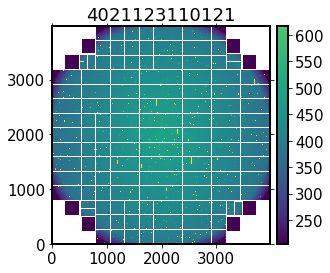

<Figure size 720x720 with 0 Axes>

In [56]:
disp = afwDisplay.Display(1, reopenPlot=True)
disp.setImageColormap('viridis')# if False else 'gray')
disp.scale('asinh', 'zscale', Q=2)
disp.mtv(mos)

plt.title(f'{dataset.dataId["exposure"]}');

plt.savefig('LsstCam_high_extra_9010121.png', bbox_inches='tight')

In [ ]:


disp.?




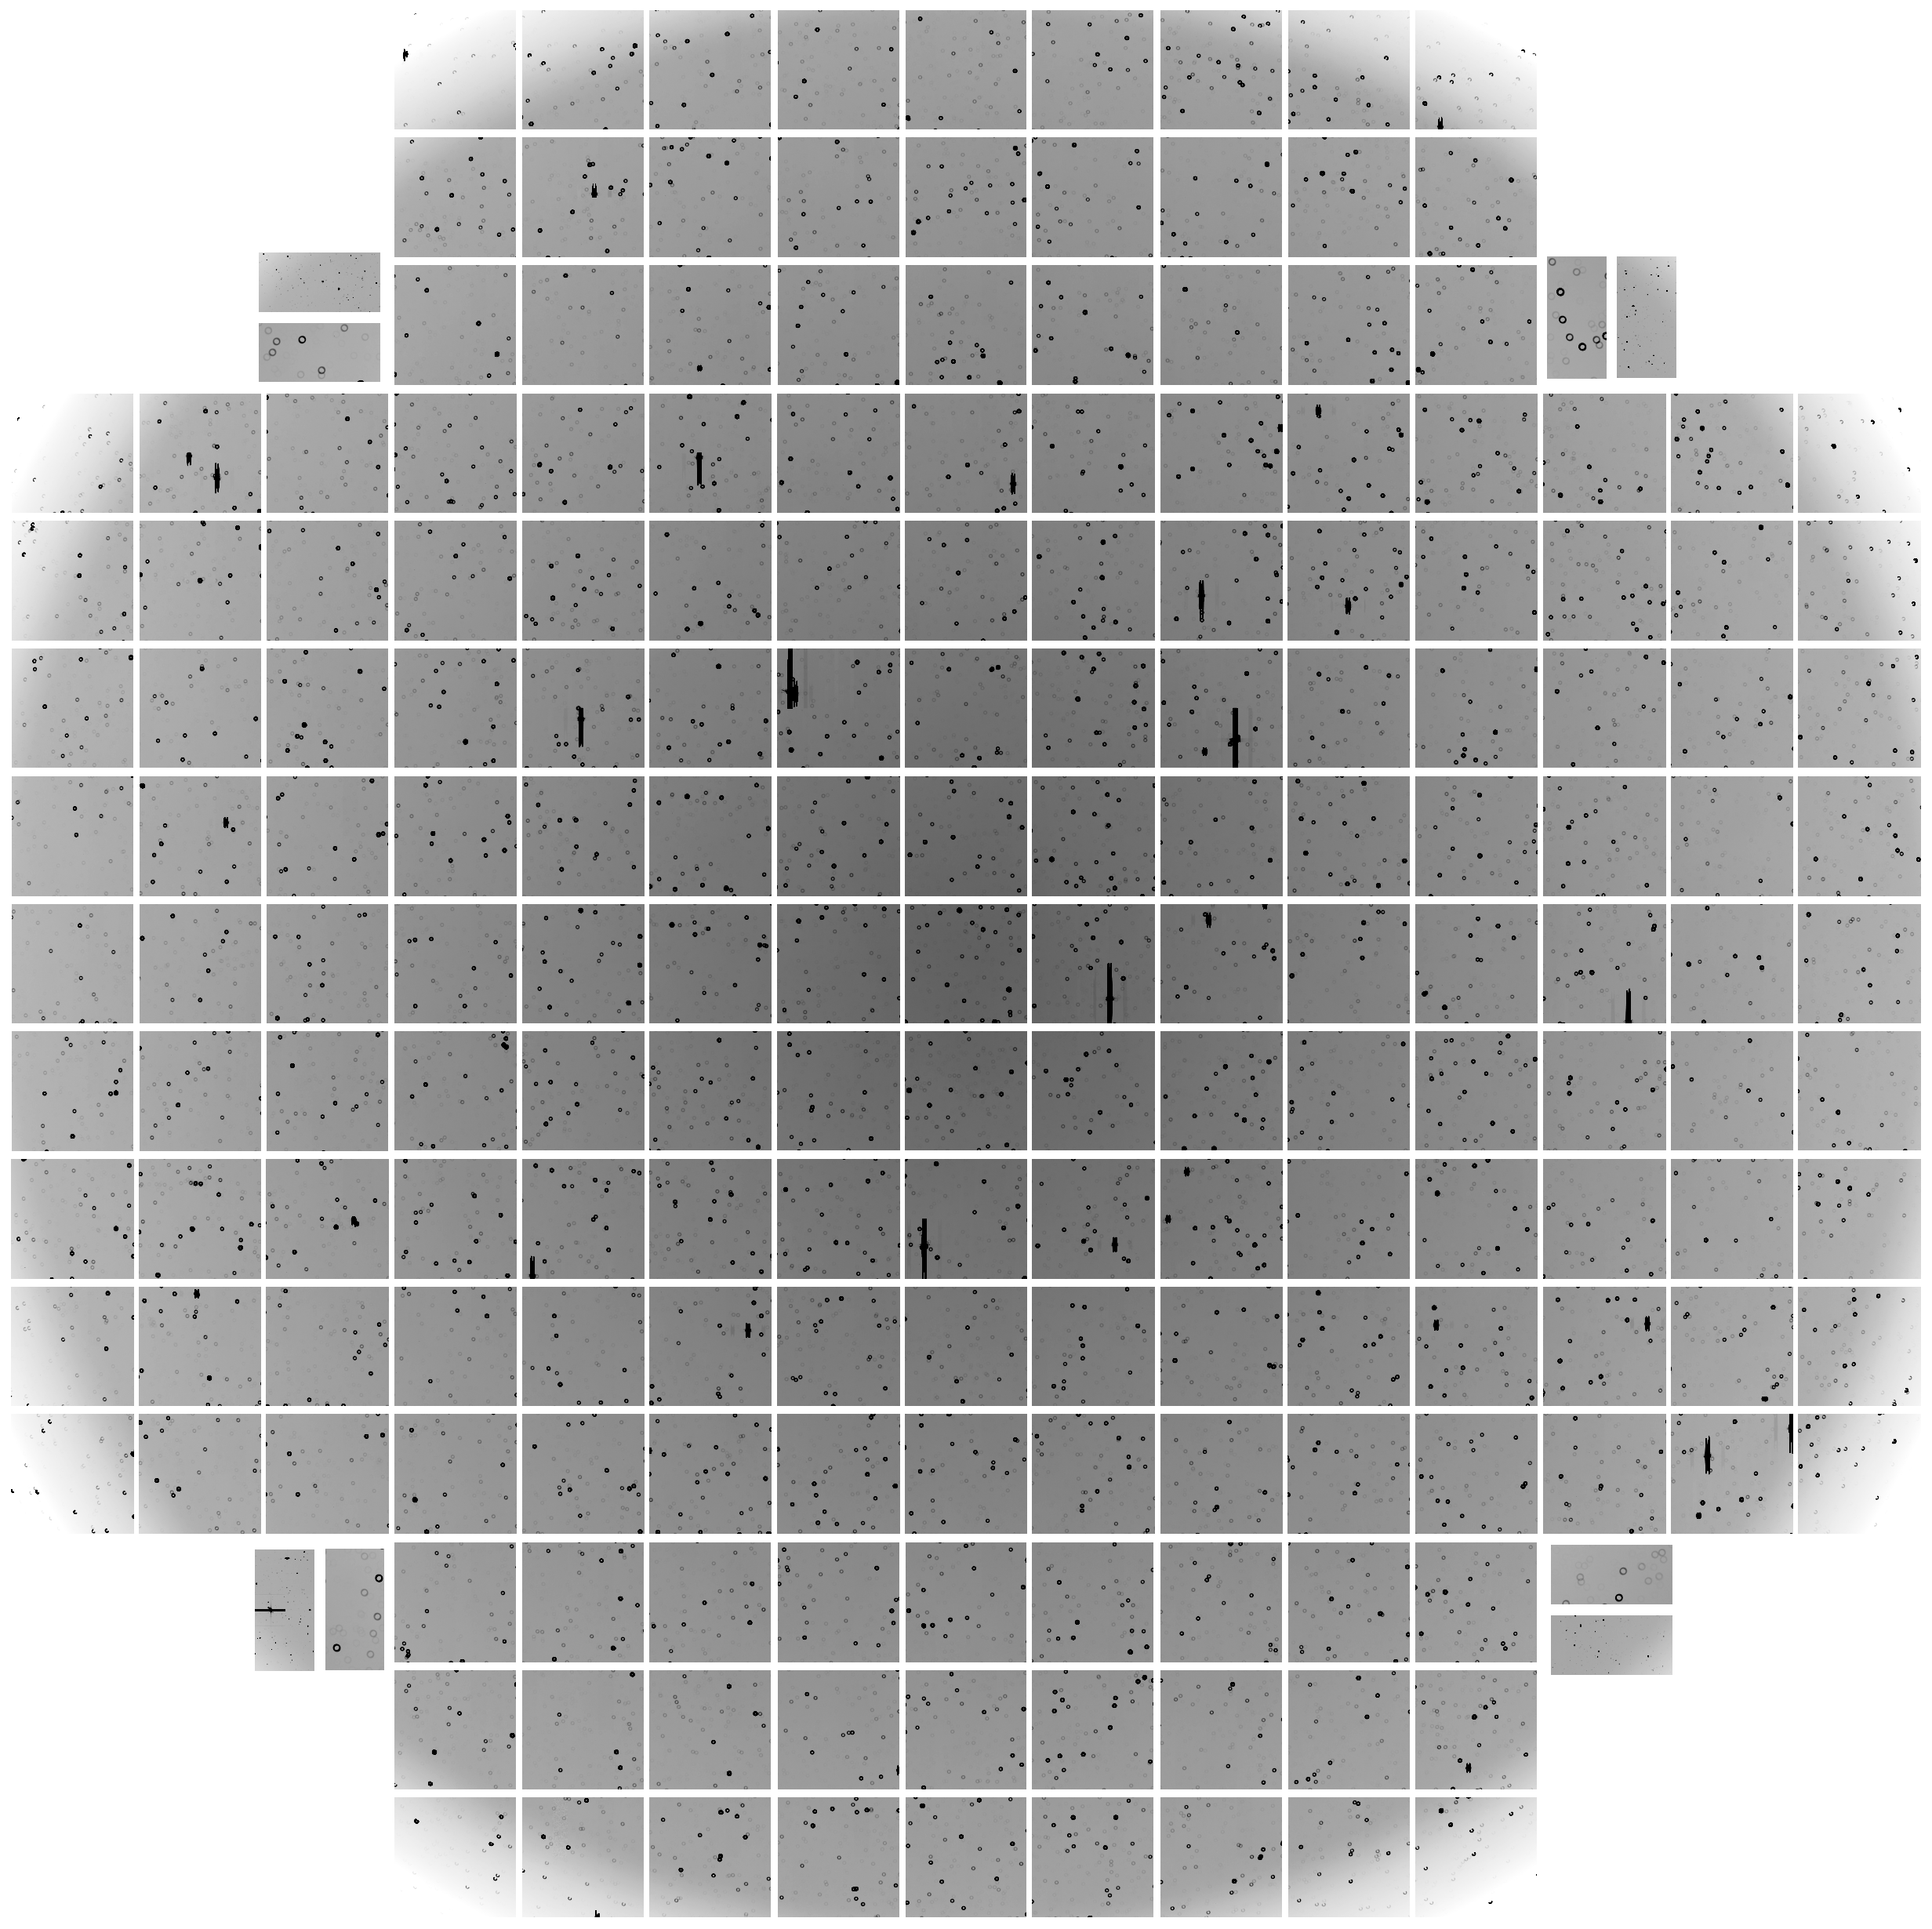

In [79]:
fig,ax = plt.subplots(1,1,figsize=(45,45))
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(mos.array)
ax.imshow(mos.array, cmap='Greys', vmin=vmin,vmax=vmax)
ax.axis("off")
plt.savefig("LsstCam_high_extra_9010121_bw_hires.png",dpi=150)

In [82]:
np.shape(mos.array)

(3974, 3980)

In [83]:
15*4000

60000

The shape is that much smaller than  approx 15*4000px = 60000 px  across, because it has been binned by a factor of 16:

The true dimensions (if binning was set to 1) would be  16 * 3974=63584, by 16*3980=63680

In [86]:
16*3980

63680